<a href="https://colab.research.google.com/github/Casardo-Chen/wikiart-neural-trasnfer/blob/main/VAE_model_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data from Google Drive


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries and utilities

In [1]:
############################
######## libraries #########
############################
# system
import os
# data science
import numpy as np
import pandas as pd
# visualization
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# pytorch(neural networks)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# vision
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image

In [2]:
PROJECT = 'Abstract Art VAE New'

In [3]:
# explore some art pictures
mode = 'local'
if mode == 'google drive':
  DATA_DIR = './drive/MyDrive/NN/wikiart-neural-transfer-GAN/Abstract_gallery/'
elif mode == 'local':
  DATA_DIR = './data/Abstract_gallery/'
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_gallery']
['Abstract_image_1745.jpg', 'Abstract_image_176.jpg', 'Abstract_image_610.jpg', 'Abstract_image_1023.jpg', 'Abstract_image_1037.jpg', 'Abstract_image_604.jpg', 'Abstract_image_2258.jpg', 'Abstract_image_1989.jpg', 'Abstract_image_162.jpg', 'Abstract_image_1751.jpg']


In [4]:
###########################
##### set parameters ######
###########################
image_size = (128,128)      # size of each image
batch_size = 100           # how many images are processing at once
latent_size = 100         # the dimensionality of the random noise vector that is used as input to the generator network
epoch_restore = 150       # epoch times

checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

learning_rate = 0.0002
beta1 = 0.5               # the exponential decay rate for the first moment estimate in the Adam optimizer
epochs = 10               # epoch times

# model hyperparameters:
latent_dim = 100
# h_dims = [32, 64, 128]
x_dim  = 12288

# load data
dataset = ImageFolder(root=DATA_DIR,
                      transform= T.Compose([T.Resize(image_size),
                                            T.ToTensor(),
                                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])           
                      )
dataloader = DataLoader(dataset=dataset, batch_size=batch_size,shuffle=True,num_workers=2)

# prep device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

# split into training set and test set
n = len(dataset)  # total number of examples
n_test = int(0.1 * n)  # take ~10% for test
testset = torch.utils.data.Subset(dataset, range(n_test))  # take first 10%
trainset = torch.utils.data.Subset(dataset, range(n_test, n))  # take the rest   
trainloader = DataLoader(dataset=trainset, batch_size=batch_size,shuffle=True,num_workers=2)
testloader = DataLoader(dataset=testset, batch_size=batch_size,shuffle=True,num_workers=2)

M_N = batch_size/n


In [5]:
# getting a batch from the dataloader 
batch = next(iter(trainloader))

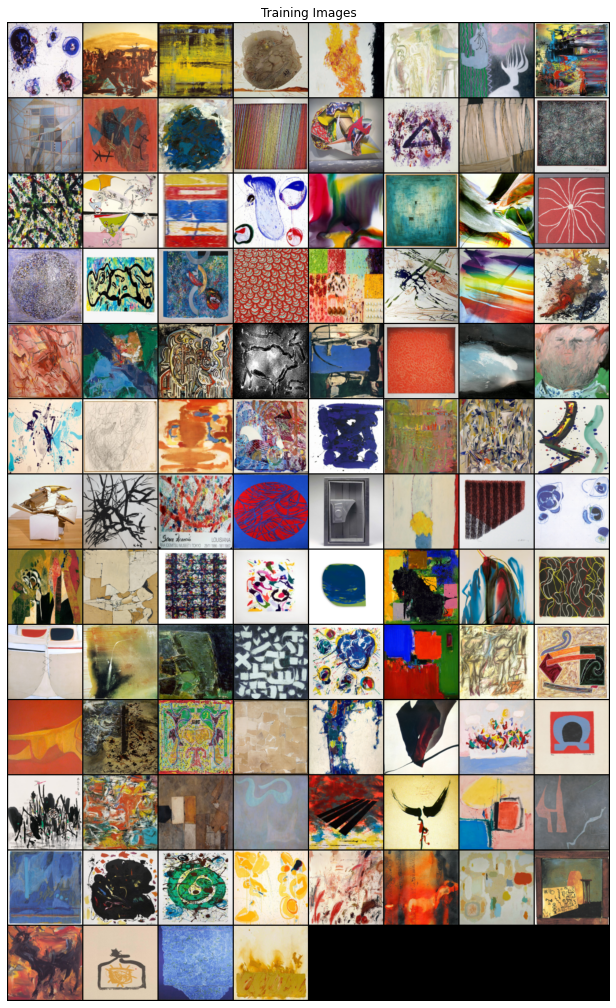

In [6]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")
# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

## VAE Model

In [23]:
def init_weights(m):
  class_name = m.__class__.__name__
  if class_name.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.05)
  elif class_name.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.05)
    nn.init.constant_(m.bias.data, 0)

In [24]:
############################
######### Encoder ##########
############################
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        # if hidden_dims is None:
        #     hidden_dims = [32,64, 128, 256, 512]

        # Build Encoder
        self.encoder = nn.Sequential(
          # conv0: input 3*128*128; output: 256*64*64 [pooling]
          nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(256),
          # conv1: input 256*64*64; output: 128*32*32 [pooling]
          nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(128),
          # conv2: input 128*32*32; output: 64*16*16 [pooling]
          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(64),
          # conv3: input 64*16*16; output: 32*8*8 [pooling]
          nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(32),
          # conv4: input 32*8*8; output: 16*4*4 [pooling]
          nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(16))

        self.fc_mu = nn.Linear(16*16, latent_dim) # 256 to 100
        self.fc_var = nn.Linear(16*16, latent_dim)

        
    def forward(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        param input: (Tensor) Input tensor to encoder [N x Channel x Height x Width]
        return: (Tensor) List of latent codes
        """
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1) # to N * (C * H * W) = 256
        # result = nn.BatchNorm2d(flatten_last_layer)
        # print(result.size())  
        # print(f'flatten:{result.size()}')
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

In [25]:
############################
######### Decoder ##########
############################
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        # if hidden_dims is None:
        #     hidden_dims = [512, 256, 128, 64, 32]
        modules = []
        self.decoder_input = nn.Linear(latent_dim, 256) # hidden_dim * height * width 100 -> 256

        # Build Decoder
        self.decoder = nn.Sequential(
          # conv1: input 16*4*4; output: 16*4*4
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(16),
          # conv2: input 16*4*4; output: 32*8*8 
          nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(32),
          # 2.1
          nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(32),
          # conv3: input 32*8*8; output: 64*16*16 
          nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(64),
          # 3.1
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(64),
          # conv4: input 64*16*16; output: 128*32*32 
          nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(128),

          # conv5: input 128*32*32; output: 256*64*64 
          nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(256),

          # conv6: input 256*64*64; output: 64*128*128 
          nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(64),

          # conv7: input 64*128*128; output: 32*128*128 
          nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(32),

          # conv8: input 32*128*128; output: 16*128*128 
          nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),

          # conv9: input 16*128*128; output: 3*128*128
          nn.Conv2d(in_channels=16, out_channels=3, kernel_size=3, stride=1,padding=1,bias=False),
          nn.Sigmoid()      
        )

        
    def forward(self, z):
        """
        Maps the given latent codes
        onto the image space.
        param z: (Tensor) [B x D]
        return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 16, 4, 4)
        result = self.decoder(result)
        # print(f'decoder:{result.size()}')
        # print(f'final:{result.size()}')
        return result

In [26]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder      
        self.Decoder = Decoder      
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z     
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
encoder = Encoder(input_dim=x_dim, latent_dim=latent_dim)
encoder.apply(init_weights)
print(encoder)
print("Trainable Parameters:", count_parameters(encoder))

# new_h_dims = h_dims.copy()
# new_h_dims.reverse()

decoder = Decoder(latent_dim=latent_dim, output_dim = x_dim)
decoder.apply(init_weights)
print(decoder)
print("Trainable Parameters:", count_parameters(decoder))

model = Model(Encoder=encoder, Decoder=decoder).to(device)

Encoder(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13

## Loss Function and Optimization

In [28]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    recons_loss = F.mse_loss(x_hat, x)
    KLD_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mean ** 2 - log_var.exp(), dim = 1), dim = 0)
    loss = recons_loss + KLD_loss
    return recons_loss , KLD_loss, loss

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Training

In [15]:
################################
######## Training Loop #########
################################
# list for tracking and training
img_list = []
iters = 0
recon_losses = []
KLD_losses = []
losses = []
print("Start training VAE...")
model.train()

# train the model
for epoch in range(epochs):
    overall_loss = 0
    for i, (x,_) in enumerate(trainloader,0):
      x = x.to(device)
      optimizer.zero_grad()
      # run model
      x_hat, mean, log_var = model(x)
      # loss
      recon_loss, KLD_loss, loss = loss_function(x, x_hat, mean, log_var)  
      overall_loss += loss.item()
      # backpropogation
      loss.backward()
      optimizer.step()
      # tqdm
      if i % 10 == 0:
        tqdm.write('[%d/%d][%d/%d]\tLoss: %.4f' % (epoch, epochs, i, len(trainloader), loss.item()))
      # add to list
      recon_losses.append(recon_loss.item())
      KLD_losses.append(KLD_loss.item())
      losses.append(loss.item())
      if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            noise = torch.randn(100, latent_dim, device=device)
            generated_images = decoder(noise)
        img_list.append(vutils.make_grid(generated_images, padding=2, normalize=True))
      iters += 1    
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (i*batch_size))
    
print("Finish training VAE")

Start training VAE...
[0/10][0/26]	Loss: 0.6304
[0/10][10/26]	Loss: 0.5667
[0/10][20/26]	Loss: 0.5512
	Epoch 1 complete! 	Average Loss:  0.005952763199806213
[1/10][0/26]	Loss: 0.5443
[1/10][10/26]	Loss: 0.4748
[1/10][20/26]	Loss: 0.4412
	Epoch 2 complete! 	Average Loss:  0.004922110569477081
[2/10][0/26]	Loss: 0.4269
[2/10][10/26]	Loss: 0.4171
[2/10][20/26]	Loss: 0.3481
	Epoch 3 complete! 	Average Loss:  0.004152015113830567
[3/10][0/26]	Loss: 0.4376
[3/10][10/26]	Loss: 0.3752
[3/10][20/26]	Loss: 0.3716
	Epoch 4 complete! 	Average Loss:  0.003672424387931824
[4/10][0/26]	Loss: 0.3553
[4/10][10/26]	Loss: 0.3215
[4/10][20/26]	Loss: 0.3523
	Epoch 5 complete! 	Average Loss:  0.0034415505528450014
[5/10][0/26]	Loss: 0.3071
[5/10][10/26]	Loss: 0.2859
[5/10][20/26]	Loss: 0.3299
	Epoch 6 complete! 	Average Loss:  0.003355006742477417
[6/10][0/26]	Loss: 0.3083
[6/10][10/26]	Loss: 0.3288
[6/10][20/26]	Loss: 0.3226
	Epoch 7 complete! 	Average Loss:  0.003388924968242645
[7/10][0/26]	Loss: 0.3266


## Visualization  of the Result

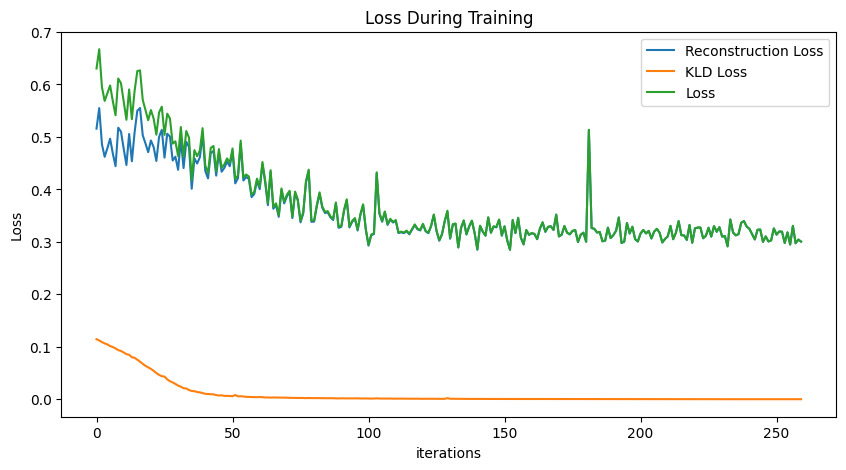

In [29]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(recon_losses,label="Reconstruction Loss")
plt.plot(KLD_losses,label="KLD Loss")
plt.plot(losses,label="Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Evaluation

In [31]:
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(trainloader)):
        x = x.view(batch_size, 3, 128, 128)
        x = x.to(device)
        
        x_hat, _, _ = model(x)
        break

  0%|          | 0/26 [00:00<?, ?it/s]

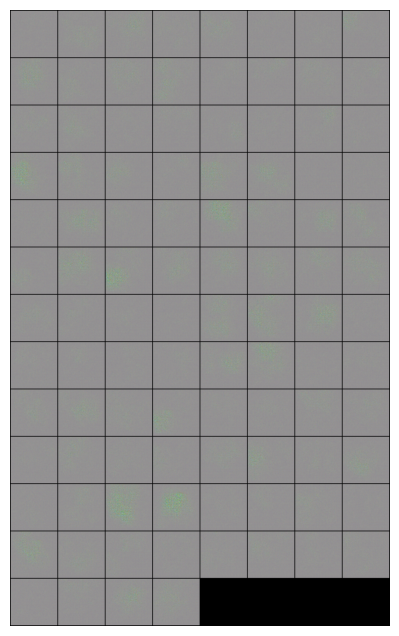

In [32]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [33]:
def show_image(x, idx):
    x = x.view(batch_size, 3, 128, 128)
    fig = plt.figure()
    plt.imshow(np.transpose(x[idx],(1,2,0)))

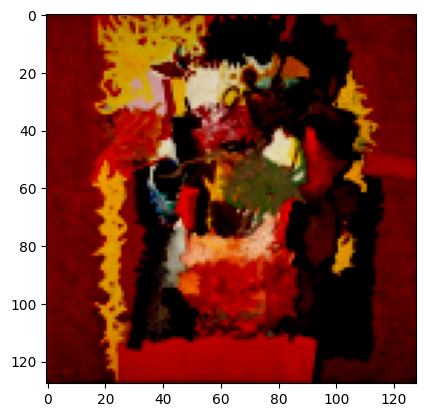

In [38]:
show_image(x, idx=10)

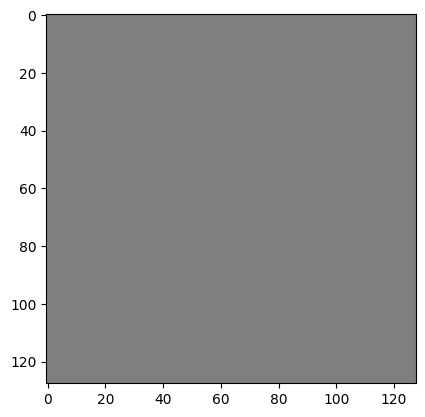

In [39]:
show_image(x_hat, idx=10)

In [36]:
with torch.no_grad():
    noise = torch.randn(100, latent_dim, device=device)
    generated_images = decoder(noise)

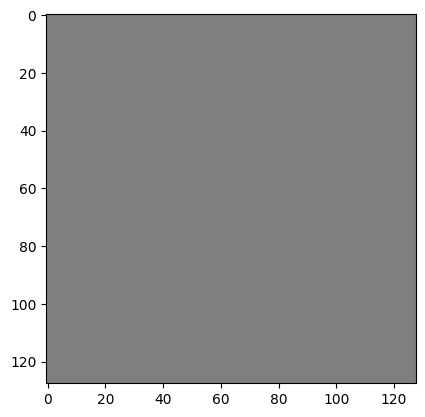

In [40]:
show_image(generated_images, idx=10)